# Surgical Dataset (Cholec 20) Processing and Annotation Exploration

This notebook loads surgical video metadata and frame annotations from AWS S3, explores the dataset structure, cleans annotation files, and prepares the data for future model training.


## Environment Setup

This section contains the required Python packages and dependencies used throughout the notebook.


In [1]:
# Importing all the required packages 
import boto3 
import pandas as pd
import numpy as np
import os 
from PIL import Image
import io 
import matplotlib.pyplot as plt

## Connecting to AWS S3

Here we establish a connection with the AWS bucket and verify access by listing available files.


In [2]:
# Configuring the dataset bucket to access the data
s3 = boto3.client('s3')
bucket = 'surgimind01' # Note : later I need to update this with env


## Dataset Structure Overview

The dataset contains folders for training, testing, and validation. Each folder includes:
- PNG or video frames
- Corresponding annotation JSON files
- Category metadata (where applicable)

Lets inspect the structure to understand naming patterns and consistency.


In [3]:
"""
Since the dataset is large (around 35 GB), S3 only returns up to 1000 keys per request. 
To avoid missing files, a paginator is used to iterate through all pages and list every object matching the prefix. 
This allows us to accurately count all frames, videos, or metadata stored under a given folder.
S3 does NOT treat folders as objects. So the solution is: count unique prefixes.
"""
prefix = "Testing/"

paginator = s3.get_paginator("list_objects_v2")

folders = set()

for page in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter="/"):
    for folder in page.get("CommonPrefixes", []):
        folders.add(folder["Prefix"])

print("Total video folders:", len(folders))
print("Folders:")
for f in folders:
    print(f)

Total video folders: 8
Folders:
Testing/VID07/
Testing/VID39/
Testing/VID01/
Testing/VID12/
Testing/VID25/
Testing/VID111/
Testing/VID06/
Testing/VID92/


In [4]:
prefix = "Training/"

paginator = s3.get_paginator("list_objects_v2")

folders = set()

for page in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter="/"):
    for folder in page.get("CommonPrefixes", []):
        folders.add(folder["Prefix"])

print("Total video folders:", len(folders))
print("Folders:")
for f in folders:
    print(f)

Total video folders: 10
Folders:
Training/VID13/
Training/VID17/
Training/VID02/
Training/VID11/
Training/VID31/
Training/VID103/
Training/VID04/
Training/VID37/
Training/VID96/
Training/VID23/


In [5]:
prefix = "Validation/"

paginator = s3.get_paginator("list_objects_v2")

folders = set()

for page in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter="/"):
    for folder in page.get("CommonPrefixes", []):
        folders.add(folder["Prefix"])

print("Total video folders:", len(folders))
print("Folders:")
for f in folders:
    print(f)

Total video folders: 2
Folders:
Validation/VID30/
Validation/VID110/


In [6]:
prefix = "Training/"

paginator = s3.get_paginator("list_objects_v2")

folders = set()

for page in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter="/"):
    for folder in page.get("CommonPrefixes", []):
        folders.add(folder["Prefix"])

print("Total video folders:", len(folders))
print("Folders:")
for f in folders:
    print(f)


Total video folders: 10
Folders:
Training/VID13/
Training/VID17/
Training/VID02/
Training/VID11/
Training/VID31/
Training/VID103/
Training/VID04/
Training/VID37/
Training/VID96/
Training/VID23/


## Dataset Summary

The dataset is split into three subsets representing different stages of the workflow.  
Each subset contains multiple folders, where each folder corresponds to a single surgical video.



### **Training Set (10 videos)**  
Contents:
- Extracted **PNG frames**
- **JSON annotation** files
- No original `.mp4` video files

Purpose: Used to train the model and learn patterns from labeled frames.



### **Testing Set (8 videos)**  
Contents:
- Original `.mp4` videos
- **JSON annotation** files
- No extracted PNG frames

Purpose: Used to evaluate the model on unseen video sequences during development.

### **Validation Set (2 videos)**  
Contents:
- Extracted **PNG frames**
- **JSON annotation** files
- No `.mp4` video files

Purpose: Used for tuning parameters and checking generalization during training.


| Split Type | Number of Videos | Contains MP4 | Contains Frames | Contains JSON |
| ---------- | ---------------- | ------------ | --------------- | ------------- |
| Training   | 10               | Yes          | Yes             | Yes           |
| Testing    | 8                | No           | Yes             | Yes           |
| Validation | 2                | No           | Yes             | Yes           |

## Loading Frames and Annotation Files

This step extracts image files and associated annotations. The goal is to map each frame with its corresponding metadata.


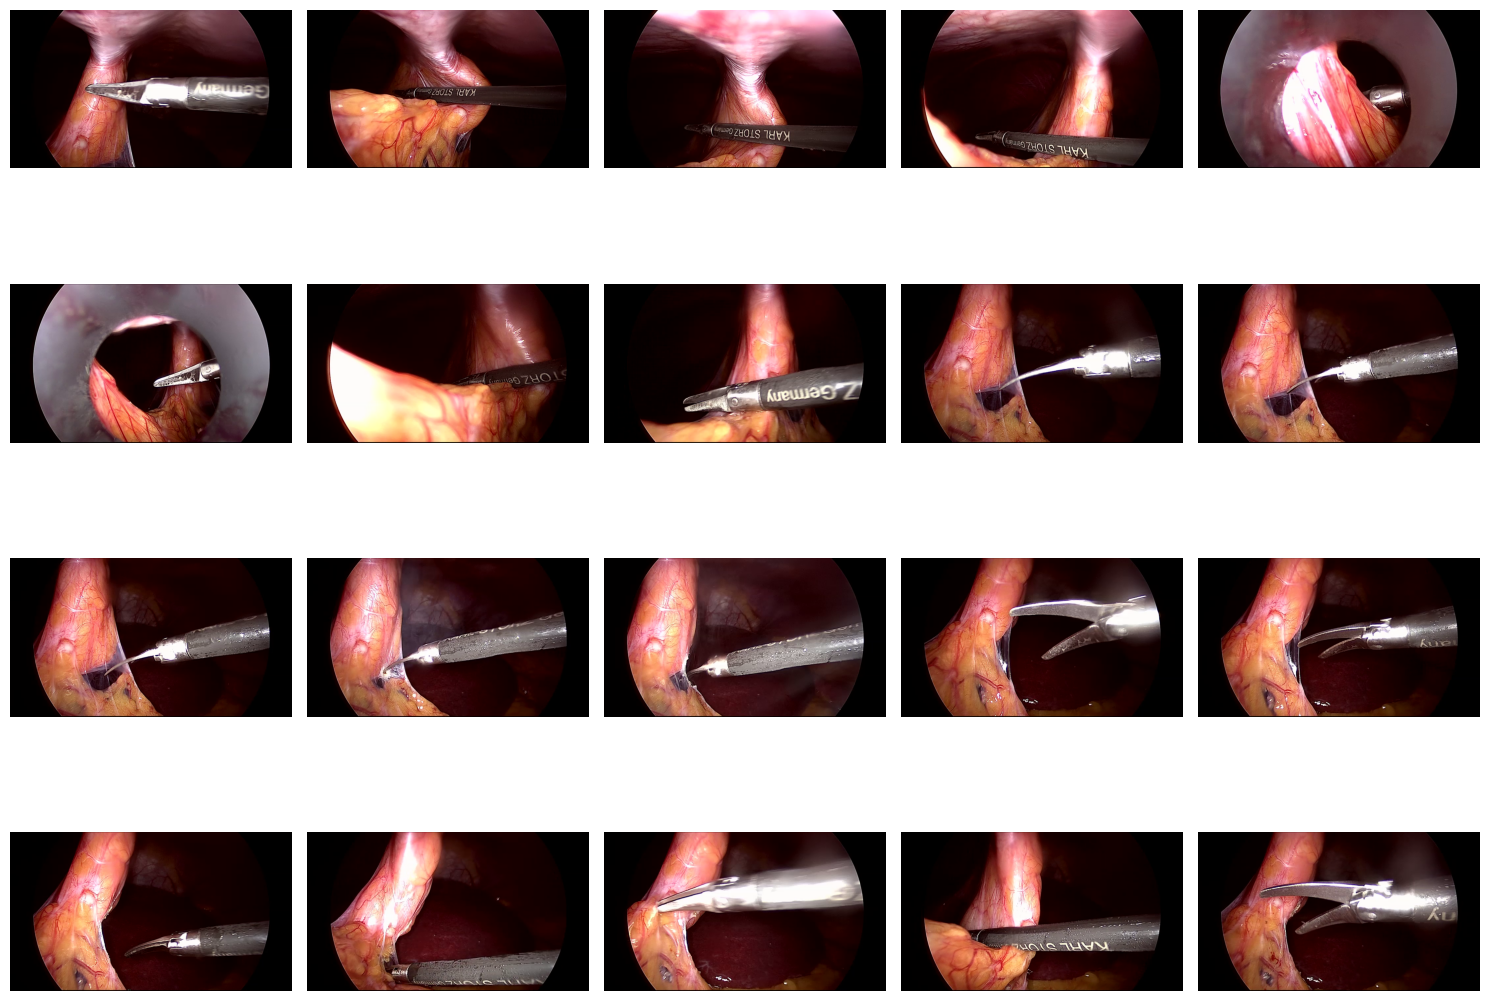

In [7]:
prefix = "Training/VID02/Frames/"

# How many frames you want to see in grid
N = 20

keys = []
paginator = s3.get_paginator("list_objects_v2")

# collect keys
for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
    for obj in page.get("Contents", []):
        keys.append(obj["Key"])
        if len(keys) >= N:
            break
    if len(keys) >= N:
        break

# download images
images = []
for key in keys:
    resp = s3.get_object(Bucket=bucket, Key=key)
    img = Image.open(io.BytesIO(resp["Body"].read()))
    images.append(img)

# build grid
cols = 5
rows = (N + cols - 1) // cols

plt.figure(figsize=(15, 3 * rows))

for i, img in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Exploratory Data Analysis (EDA)

We check distribution of annotations, category frequency, sample frames, and dataset consistency to better understand labeling patterns.


In [8]:
# reading the json data of the frames of the specific video 

df = pd.read_json(r"s3://surgimind01/Training/VID02/vid02.json")

In [9]:
df.shape

(2562, 4)

In [10]:
df.head(10)

,info,annotations,categories,video
dataset,CholecTrack20,NaN,NaN,NaN
description,Laparoscopic cholecystectomy video dataset for...,NaN,NaN,NaN
year,2022,NaN,NaN,NaN
version,1.0,NaN,NaN,NaN
author,Chinedu I. Nwoye,NaN,NaN,NaN
copyright,"CAMMA, ICube, University of Strasbourg, France",NaN,NaN,NaN
url,http://camma.u-strasbg.fr/,NaN,NaN,NaN
date_created,2019-01-01,NaN,NaN,NaN
bbox format,"tlwh = [top_left_x, top_left_y, box_width, box...",NaN,NaN,NaN
license,Creative Commons license CC BY-NC-SA 4.0 LICEN...,NaN,NaN,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2562 entries, dataset to width
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   info         10 non-null     object
 1   annotations  2545 non-null   object
 2   categories   2 non-null      object
 3   video        5 non-null      object
dtypes: object(4)
memory usage: 100.1+ KB


In [12]:
df['annotations']

dataset        NaN
description    NaN
year           NaN
version        NaN
author         NaN
              ... 
name           NaN
num_frames     NaN
split          NaN
height         NaN
width          NaN
Name: annotations, Length: 2562, dtype: object

## Cleaning and Normalizing Annotation Data

Some annotation files contain nested structures. We convert them into a usable tabular format for analysis and training.


In [13]:
"""
Step-by-step process to flatten the nested 'annotations' column.

1. Filter out rows where 'annotations' is empty or NaN.
2. Explode the column so each list item becomes a separate row.
3. Normalize each dictionary in the exploded column into individual columns.
4. Preview the structured flattened data.
"""
from pandas import json_normalize
pd.set_option('display.max_columns', None)
df_ann = df[df["annotations"].notna()].copy()
df_ann = df_ann.explode("annotations")
df_ann_flat = json_normalize(df_ann["annotations"])
df_ann_flat.head()


,instrument,verb,target,phase,triplet,tool_bbox,operator,iscrowd,area,score,intraoperative_track,intracorporeal_track,visibility_track,visibility,crowded,visible,occluded,bleeding,smoke,blurred,undercoverage,reflection,stainedlens
0,3,-1,-1,0,-1,"[0.268149882903981, 0.42916666666666603, 0.364...",3,0,47174.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0
1,3,-1,-1,0,-1,"[0.300936768149882, 0.49166666666666603, 0.093...",3,0,60652.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0
2,3,-1,-1,0,-1,"[0.28337236533957805, 0.716666666666666, 0.114...",3,0,83248.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0
3,3,-1,-1,0,-1,"[0.26346604215456604, 0.7645833333333331, 0.11...",3,0,82575.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0
4,3,-1,-1,0,-1,"[0.5807962529274, 0.47500000000000003, 0.15339...",3,0,113088.0,1.0,1,1,1,1,0,1,0,0,0,0,1,0,0


In [14]:
df_ann_flat['frame_id'] =6701

In [15]:
df_ann_flat.tail()

,instrument,verb,target,phase,triplet,tool_bbox,operator,iscrowd,area,score,intraoperative_track,intracorporeal_track,visibility_track,visibility,crowded,visible,occluded,bleeding,smoke,blurred,undercoverage,reflection,stainedlens,frame_id
4123,0,-1,-1,6,-1,"[0.18032786885245902, 0.45833333333333304, 0.2...",2,0,33880.0,1.0,4,4,157,1,0,1,0,0,0,0,1,0,1,6701
4124,6,-1,-1,6,-1,"[0.12412177985948401, 0.6666666666666661, 0.14...",0,0,33920.0,1.0,9,19,158,1,0,1,0,0,0,0,0,0,1,6701
4125,6,-1,-1,6,-1,"[0.12412177985948401, 0.622916666666666, 0.288...",0,0,31694.0,1.0,9,19,158,1,0,1,0,0,0,0,0,0,1,6701
4126,0,-1,-1,6,-1,"[0.38992974238875805, 0.39375000000000004, 0.1...",2,0,62937.0,1.0,4,4,157,1,0,1,0,0,0,0,1,0,1,6701
4127,0,-1,-1,6,-1,"[0.34074941451990604, 0.385416666666666, 0.258...",2,0,53835.0,1.0,4,4,157,1,0,1,0,0,0,0,1,0,1,6701


In [16]:
df_categories = df[df["categories"].notna()].copy()
df_categories = df_categories.explode("categories")
df_categories_flat = json_normalize(df_categories["categories"])
df_categories_flat


,id,name,supercategory,multi-instance
0,0,grasper,grasper,True
1,1,bipolar,grasper,False
2,2,hook,hook,False
3,3,scissors,scissors,False
4,4,clipper,clipper,False
5,5,irrigator,irrigator,False
6,6,specimen-bag,specimen-bag,False
7,0,null,NaN,NaN
8,1,main-surgeon-left-hand (MSLH),NaN,NaN
9,2,assistant-surgeon-right-hand (ASRH),NaN,NaN


### Category Distribution
This helps us understand which instruments appear most frequently.

In [17]:
df_ann_flat['instrument'].value_counts()


instrument
0    1967
2    1509
3     216
5     169
1     127
4      70
6      70
Name: count, dtype: int64

instrument
0    1001
1      78
2     740
3      40
4      37
6     109
Name: count, dtype: int64


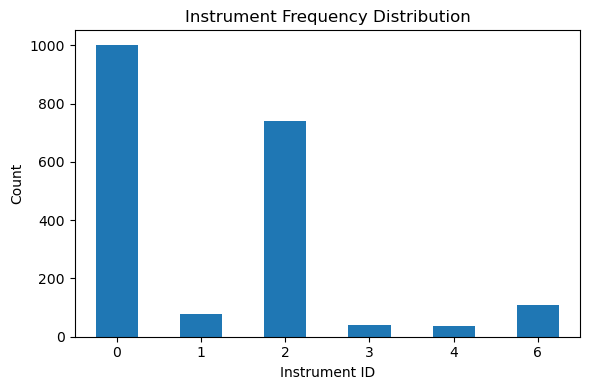

In [30]:

# Count occurrences of each instrument
instrument_counts = df_ann_flat['instrument'].value_counts().sort_index()

# Display counts as a table
print(instrument_counts)

# Plot
plt.figure(figsize=(6, 4))
instrument_counts.plot(kind='bar')

plt.title("Instrument Frequency Distribution")
plt.xlabel("Instrument ID")
plt.ylabel("Count")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Loading Frames and Annotation Files

This step extracts image files and associated annotations. The goal is to map each frame with its corresponding metadata.


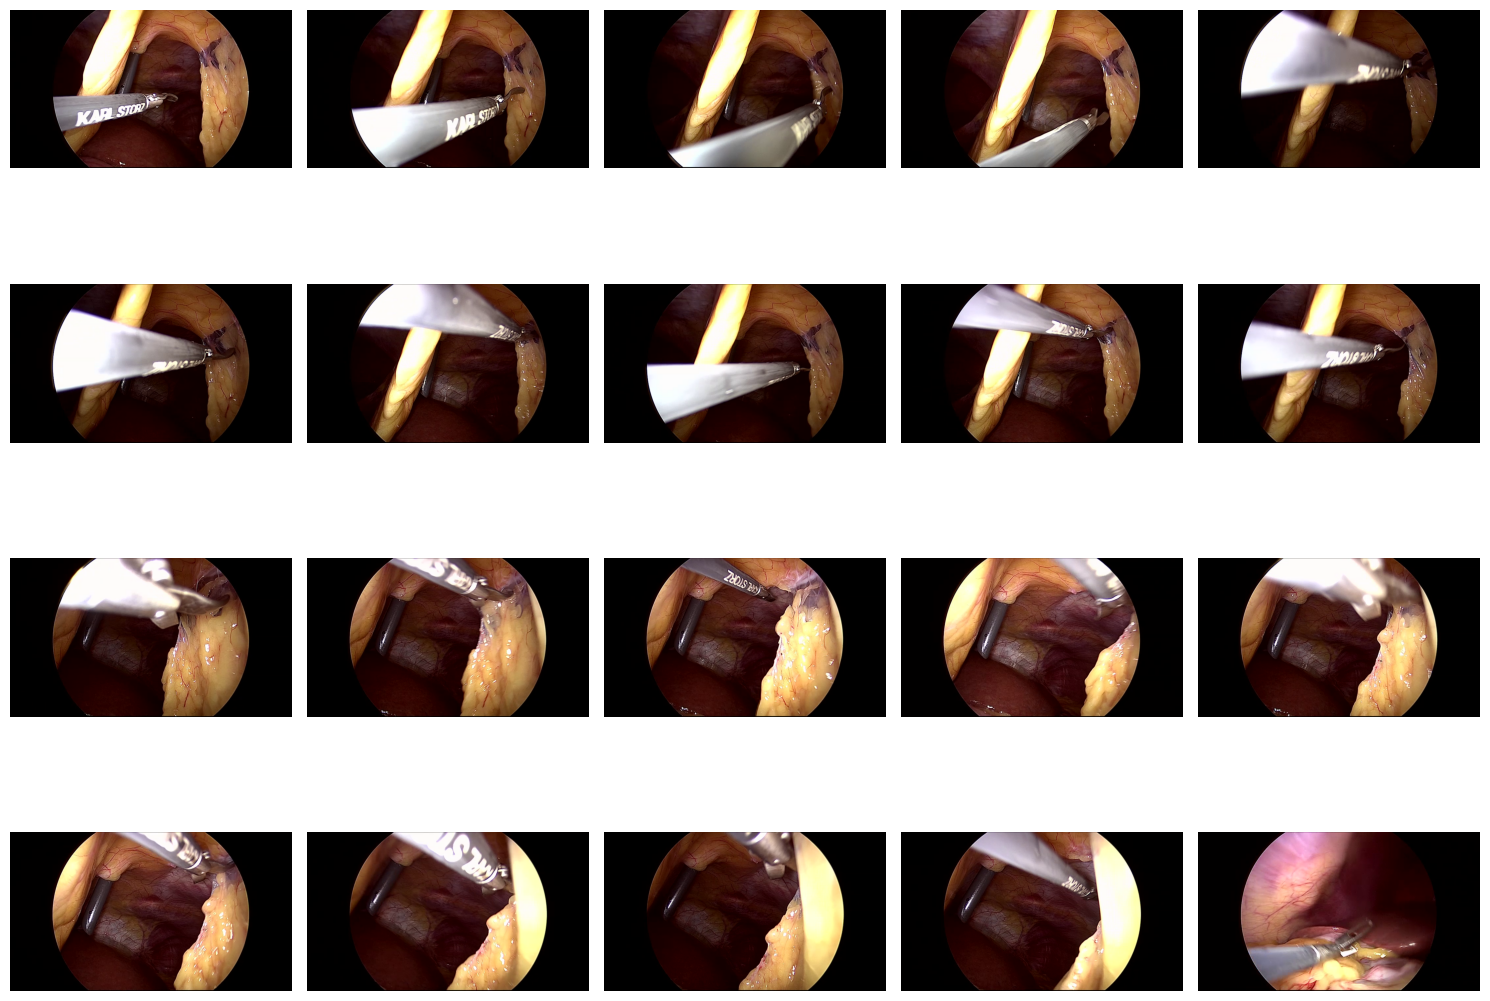

In [19]:
## So from the above we got instrumemts id's and there name
## now lets check this for for other videos
prefix = "Training/VID04/Frames/"

# How many frames you want to see in grid
N = 20

keys = []
paginator = s3.get_paginator("list_objects_v2")

# collect keys
for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
    for obj in page.get("Contents", []):
        keys.append(obj["Key"])
        if len(keys) >= N:
            break
    if len(keys) >= N:
        break

# download images
images = []
for key in keys:
    resp = s3.get_object(Bucket=bucket, Key=key)
    img = Image.open(io.BytesIO(resp["Body"].read()))
    images.append(img)

# build grid
cols = 5
rows = (N + cols - 1) // cols

plt.figure(figsize=(15, 3 * rows))

for i, img in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [20]:
df = pd.read_json(r"s3://surgimind01/Training/VID04/vid04.json")

In [21]:
df.shape

(1206, 4)

In [22]:
df.head(10)

,info,annotations,categories,video
dataset,CholecTrack20,NaN,NaN,NaN
description,Laparoscopic cholecystectomy video dataset for...,NaN,NaN,NaN
year,2022,NaN,NaN,NaN
version,1.0,NaN,NaN,NaN
author,Chinedu I. Nwoye,NaN,NaN,NaN
copyright,"CAMMA, ICube, University of Strasbourg, France",NaN,NaN,NaN
url,http://camma.u-strasbg.fr/,NaN,NaN,NaN
date_created,2019-01-01,NaN,NaN,NaN
bbox format,"tlwh = [top_left_x, top_left_y, box_width, box...",NaN,NaN,NaN
license,Creative Commons license CC BY-NC-SA 4.0 LICEN...,NaN,NaN,NaN


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1206 entries, dataset to width
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   info         10 non-null     object
 1   annotations  1189 non-null   object
 2   categories   2 non-null      object
 3   video        5 non-null      object
dtypes: object(4)
memory usage: 47.1+ KB


In [24]:
df['annotations']

dataset        NaN
description    NaN
year           NaN
version        NaN
author         NaN
              ... 
name           NaN
num_frames     NaN
split          NaN
height         NaN
width          NaN
Name: annotations, Length: 1206, dtype: object

In [25]:
"""
Step-by-step process to flatten the nested 'annotations' column.

1. Filter out rows where 'annotations' is empty or NaN.
2. Explode the column so each list item becomes a separate row.
3. Normalize each dictionary in the exploded column into individual columns.
4. Preview the structured flattened data.
"""
from pandas import json_normalize
pd.set_option('display.max_columns', None)
df_ann = df[df["annotations"].notna()].copy()
df_ann = df_ann.explode("annotations")
df_ann_flat = json_normalize(df_ann["annotations"])
df_ann_flat.head()


,instrument,verb,target,phase,triplet,tool_bbox,operator,iscrowd,area,score,intraoperative_track,intracorporeal_track,visibility_track,visibility,crowded,visible,occluded,bleeding,smoke,blurred,undercoverage,reflection,stainedlens
0,3,-1,-1,0,-1,"[0.459016393442622, 0.5145833333333331, 0.1393...",1,0,96824.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0
1,3,-1,-1,0,-1,"[0.620608899297423, 0.48541666666666605, 0.153...",1,0,123490.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0
2,3,-1,-1,0,-1,"[0.73887587822014, 0.48541666666666605, 0.0784...",1,0,147023.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0
3,3,-1,-1,0,-1,"[0.638173302107728, 0.616666666666666, 0.10070...",1,0,161320.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0
4,3,-1,-1,0,-1,"[0.7295081967213111, 0.25, 0.11592505854800901...",1,0,74760.0,1.0,1,1,1,1,0,1,0,0,0,0,0,0,0


In [26]:
df_categories = df[df["categories"].notna()].copy()
df_categories = df_categories.explode("categories")
df_categories_flat = json_normalize(df_categories["categories"])
df_categories_flat


,id,name,supercategory,multi-instance
0,0,grasper,grasper,True
1,1,bipolar,grasper,False
2,2,hook,hook,False
3,3,scissors,scissors,False
4,4,clipper,clipper,False
5,5,irrigator,irrigator,False
6,6,specimen-bag,specimen-bag,False
7,0,null,NaN,NaN
8,1,main-surgeon-left-hand (MSLH),NaN,NaN
9,2,assistant-surgeon-right-hand (ASRH),NaN,NaN


In [27]:
df_ann_flat['instrument'].value_counts()

instrument
0    1001
2     740
6     109
1      78
3      40
4      37
Name: count, dtype: int64

instrument
0    1001
1      78
2     740
3      40
4      37
6     109
Name: count, dtype: int64


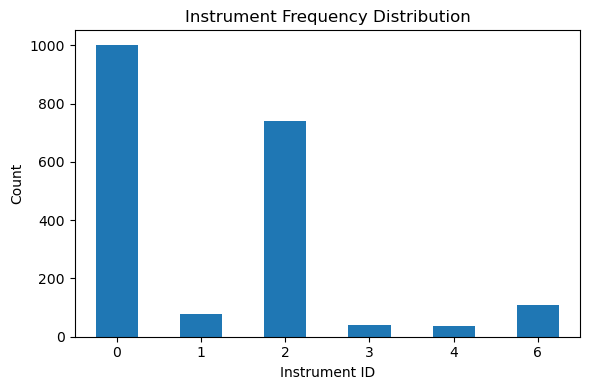

In [28]:

# Count occurrences of each instrument
instrument_counts = df_ann_flat['instrument'].value_counts().sort_index()

# Display counts as a table
print(instrument_counts)

# Plot
plt.figure(figsize=(6, 4))
instrument_counts.plot(kind='bar')

plt.title("Instrument Frequency Distribution")
plt.xlabel("Instrument ID")
plt.ylabel("Count")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()